# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

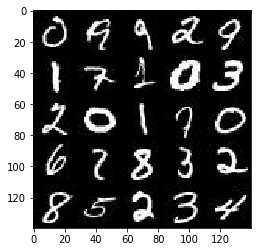

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

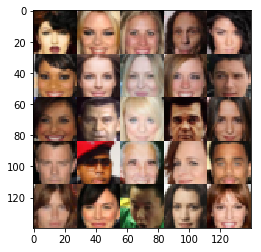

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
      
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0906... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 2.0915... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 2.1002... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 2.0290... Generator Loss: 0.2216
Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.7280... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.5019
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.4099


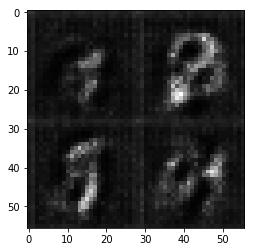

Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.4092
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 1.5936
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.5726
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.6058


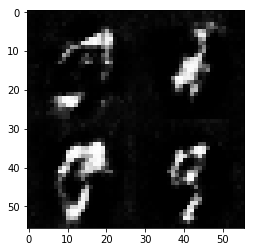

Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.5674... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 1.3220
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.3860


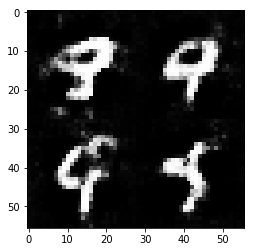

Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.4289
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.3752
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 1.1413
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.6264


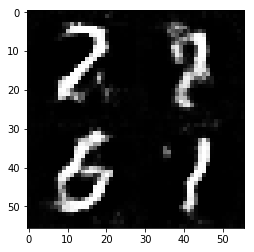

Epoch 1/2... Discriminator Loss: 1.6559... Generator Loss: 1.4826
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.2838
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.9949


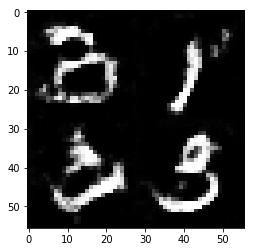

Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.4833... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.4511
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.4357
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.5777


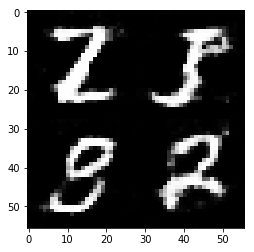

Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 1.2925
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 0.6286
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.3454
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.3578


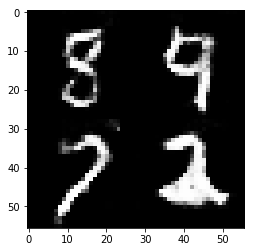

Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.2770
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.6871


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1777... Generator Loss: 0.0737
Epoch 1/1... Discriminator Loss: 3.2457... Generator Loss: 0.2022
Epoch 1/1... Discriminator Loss: 2.2179... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 2.0550... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 2.2061... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.8853... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.7672... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.6569


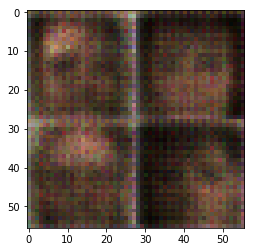

Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7113


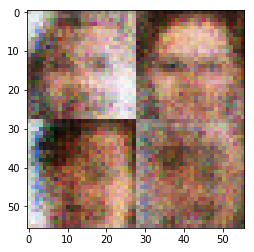

Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5827


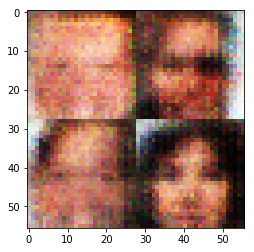

Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.5716


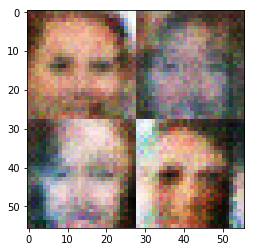

Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6451


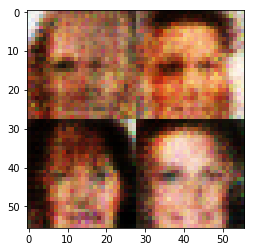

Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6595


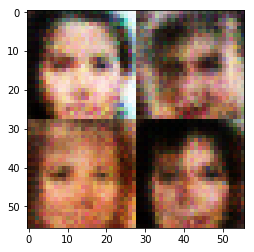

Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6717


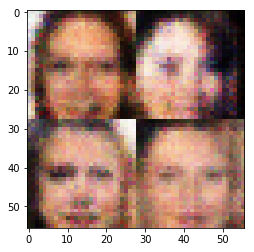

Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6707


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.